# **Lab Semantic Segmentation**

# Objective:
Train  Fully Convolutional Neural Network for Change Detection in a Region of the Cerrado Biome

# Dataset
Two images acquired at two different dates in a region of the Cerrado Biome

**Sensor:** Landsat 8

**Bands:** 7 (each image)

**Spatial Resolution:** 30m x 30m

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/img_t1_t2_001.png'/>
</figure>


---

# Methodology
<center>
<img src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/methodology_001.png'/>
</center>







In [ ]:
from google.colab import drive
# mount your Google Drive
drive.mount('/content/drive', force_remount=True)
root_path = '/content/drive/My Drive/Colab Notebooks/' 

Mounted at /content/drive


# **Import libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from numpy import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

# **Define our network**

In [ ]:
# Define our network
def FCN(input_shape, n_classes):
  # Input shape = 128 x 128 x 14
  # n_classes = 2 (0 - No def, 1 - Def)
  input_img = Input(input_shape)
  n_filters = [32, 64, 128, 256]
  ## ENCODER
  conv1 = Conv2D(n_filters[0] , (3 , 3) , activation='relu' , padding='same', name = 'conv1')(input_img) 
  pool1 = MaxPool2D((2 , 2), name = 'MaxPooling1')(conv1)

  conv2 = Conv2D(n_filters[1], (3 , 3) , activation='relu' , padding='same', name = 'conv2')(pool1)
  pool2 = MaxPool2D((2 , 2), name = 'MaxPooling2')(conv2)

  conv3 = Conv2D(n_filters[2] , (3 , 3) , activation='relu' , padding='same', name = 'conv3')(pool2)
  pool3 = MaxPool2D((2 , 2), name = 'MaxPooling3')(conv3)

  conv4 = Conv2D(n_filters[3] , (3 , 3) , activation='relu' , padding='same', name = 'conv4')(pool3)

  ## DECODER
  upsample1 = Conv2D(n_filters[2], (3 , 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2), name = 'upsampling1')(conv4))

  upsample2 = Conv2D(n_filters[1], (3 , 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2), name = 'upsampling2')(upsample1))

  upsample3 = Conv2D(n_filters[0], (3 , 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2), name = 'upsampling3')(upsample2))
  
  # OUTPUT
  output = Conv2D(n_classes,(1,1), activation = 'softmax')(upsample3)
  
  return Model(input_img , output) 

def weighted_categorical_crossentropy(weights):
  """
  A weighted version of keras.objectives.categorical_crossentropy
  
  Variables:
      weights: numpy array of shape (C,) where C is the number of classes
  
  Usage:
      weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
      loss = weighted_categorical_crossentropy(weights)
      model.compile(loss=loss,optimizer='adam')
  """
  weights = K.variable(weights)
  def loss(y_true, y_pred):
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    loss = y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred)
    loss = loss * weights 
    loss = - K.mean(loss, -1)
    return loss
  return loss

# **Load data**

In [ ]:
# take around one minute clone the project
!git clone https://gitlab.com/mabelortega.12/dl_semantic_segmentation.git

Cloning into 'dl_semantic_segmentation'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
!unzip dl_semantic_segmentation/Data.zip

Archive:  dl_semantic_segmentation/Data.zip
   creating: Data/
  inflating: Data/tr_patches.npy     
  inflating: Data/tr_ref.npy         
  inflating: Data/ts_patches.npy     
  inflating: Data/ts_ref.npy         


In [ ]:
# Training patches
patches_tr = np.load('Data/tr_patches.npy')
patches_tr_ref = np.load('Data/tr_ref.npy')
print('patches train size: ', patches_tr.shape)
print('patches ref size: ', patches_tr_ref.shape)

patches train size:  (324, 128, 128, 14)
patches ref size:  (324, 128, 128)


# **One-hot-encoding**

<center>
<img align="center" width="400" height="300" src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/One_hot_encoding.jpeg'>
</center>

In [ ]:
# One hot enconding
number_class = 2
patches_tr_ref_h = tf.keras.utils.to_categorical(patches_tr_ref, number_class)
print(patches_tr_ref_h.shape)


(324, 128, 128, 2)


In [ ]:
# Set weights
weights = [0.2, 0.8]
#weights = weights/np.sum(weights)
print(weights)

[0.2, 0.8]


# **Train model**

In [ ]:
# Parameters
batch_size = 32
learning_rate = 1e-3
epochs = 100
channels = 14
patch_size = 128
number_class = 2
name = 'fcn'

In [ ]:
# Function for training our model
def Train_model(net, patches_train, patches_tr_lb_h, batch_size, epochs, filepath, name):
  print('Start training.. ')
  for epoch in range(epochs):

    loss_tr = np.zeros((1 , 2))
    #Computing the number of batchs
    n_batchs_tr = patches_train.shape[0]//batch_size
    
    #Random shuffle the data
    patches_train , patches_tr_lb_h = shuffle(patches_train , patches_tr_lb_h , random_state = 0)
        
    # Training the network per batch
    for  batch in range(n_batchs_tr):
                
      x_train_b = patches_train[batch * batch_size : (batch + 1) * batch_size , : , : , :]
      y_train_h_b = patches_tr_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :, :]
      
      loss_tr = loss_tr + net.train_on_batch(x_train_b , y_train_h_b)
    
    # Training loss
    loss_tr = loss_tr/n_batchs_tr
    
    print("%d [training loss: %f , Train acc.: %.2f%%]" %(epoch , loss_tr[0 , 0], 100*loss_tr[0 , 1]))
  # saving model    
    net.save(root_path+name+'.h5')


adam = Adam(lr = learning_rate , beta_1=0.9)
net = FCN((patch_size, patch_size, channels), number_class)
net.summary()
loss = weighted_categorical_crossentropy(weights)
net.compile(loss = loss,optimizer=adam , metrics=['accuracy'])
Train_model(net, patches_tr, patches_tr_ref_h, batch_size, epochs, root_path, name)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 14)]    0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      4064      
                                                                 
 MaxPooling1 (MaxPooling2D)  (None, 64, 64, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 64, 64)        18496     
                                                                 
 MaxPooling2 (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 32, 32, 128)       73856     
                                                                 
 MaxPooling3 (MaxPooling2D)  (None, 16, 16, 128)       0     

# **Test model**

In [ ]:
# Function for testing our model
def Test_model(model, patches_test):
  result = model.predict(patches_test)
  predicted_class = np.argmax(result, axis=-1)
  return predicted_class

In [ ]:
# Test samples
patches_ts = np.load('Data/ts_patches.npy')
patches_ts_ref = np.load('Data/ts_ref.npy')

# Loading pretraining model
model = load_model(root_path+name+'.h5', compile=False)
patches_pred = Test_model(model, patches_ts)
print('final label shape:', patches_pred.shape)

final label shape: (48, 128, 128)


# **Metrics**

<center>
<img align="center" width="700" height="300" src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/Metrics.png'>
</center>



In [ ]:
# Computing metrics
def compute_metrics(true_labels, predicted_labels):
  accuracy = 100*accuracy_score(true_labels, predicted_labels)
  f1score = 100*f1_score(true_labels, predicted_labels, average=None)
  recall = 100*recall_score(true_labels, predicted_labels, average=None)
  precision = 100*precision_score(true_labels, predicted_labels, average=None)
  return accuracy, f1score, recall, precision

In [ ]:
true_labels = patches_ts_ref.ravel()
predicted_labels = patches_pred.ravel()

metrics = compute_metrics(true_labels, predicted_labels)
cm = confusion_matrix(true_labels, predicted_labels)

print('Confusion  matrix \n', cm)
print('Accuracy: ', metrics[0])
print('F1score: ', metrics[1])
print('Recall: ', metrics[2])
print('Precision: ', metrics[3])

Confusion  matrix 
 [[738957   5800]
 [ 11690  29985]]
Accuracy:  97.77603149414062
F1score:  [98.8304164  77.42060418]
Recall:  [99.22122249 71.94961008]
Precision:  [98.44267678 83.79209166]


# **Visualization**

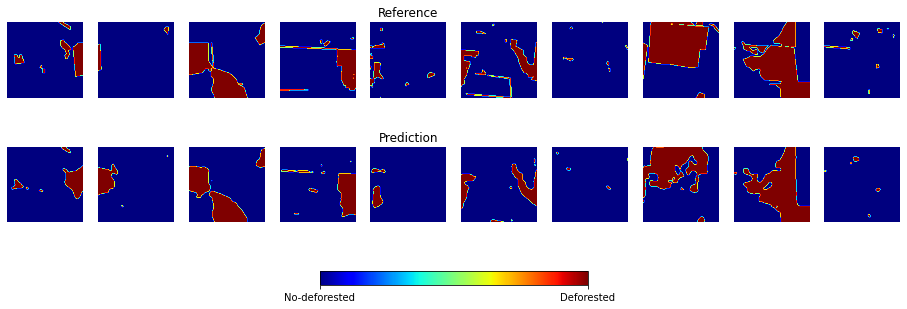

In [ ]:
def PlotPred(X, Y, num_samples=10, color = True, cmap = None):
    nr = 2 
    fig, axes = plt.subplots(nrows=nr, ncols=num_samples, figsize=(16, 6))

    for i in range(0,num_samples):
        im = axes[0,i].imshow(X[i], cmap=cmap)
        axes[0,i].axis('off')
        axes[0,4].title.set_text('Reference')
        im = axes[1,i].imshow(Y[i], cmap=cmap)
        axes[1,i].axis('off')
        axes[1,4].title.set_text('Prediction')
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, ticks=[0, 1], location='bottom')
    cbar.ax.set_xticklabels(['No-deforested', 'Deforested']) 

ii = 15
PlotPred(patches_ts_ref[ii:ii+10], patches_pred[ii:ii+10], cmap = 'jet')

# **Exercise**
Fill the next table varying the parameters

link for results [https://docs.google.com/document/d/1c2E4ipCnmk9Xrsmls-CGYNF6GXX50ucW86-GflbYMqM/edit?usp=sharing]

Name        || Learning rate || Batch size || Filters || Prec. || Rec. || F1 ||
 --- || --- || --- || --- || --- || --- || --- ||
1   ||  **'1e-1'**   ||  **8**     || **[8,16,32,64]**   || - || - || - ||
2 ||  **'1e-2'**   ||  **16**    || **[8,16,32,64]**   || - || - || - ||
3       ||  **'1e-4'**   ||  **32**    || **[16,32,64,128]** || - || - || - ||
4       ||  **'1e-5'**   ||  **64**    || **[16,32,64,128]** || - || - || - ||
5        ||  **'1e-3'**   ||  **8**     || **[32,64,128,256]**|| - || - || - ||
6        ||  **'1e-3'**   ||  **16**    || **[32,64,128,256]**|| - || - || - ||
7        ||  **'1e-3'**   ||  **32**    || **[32,64,128,256]**|| - || - || - ||
8        ||  **'1e-3'**   ||  **64**    || **[32,64,128,256]**|| - || - || - ||
9        ||  **'1e-5'**   ||  **16**    || **[32,64,128,256]**|| - || - || - ||
10        ||  **'1e-5'**   ||  **32**    || **[32,64,128,256]**|| - || - || - ||
11        ||  **'1e-5'**   ||  **64**    || **[32,64,128,256]**|| - || - || - ||
12        ||  **'1e-3'**   ||  **32**    || **[64,128,256,512]**|| - || - || - ||
13        ||  **'1e-3'**   ||  **64**    || **[64,128,256,512]**|| - || - || - ||

